# Rare variant effects

This analysis aimed to answer the following research question: **Which of the variants with rare frequencies in African populations are most likely to contribute to disease, based on predicted effect on protein structure and function?**

To achieve this, the following steps were performed:

1. Genetic Variant Effect Data Retrieval and Preparation: Genetic variant effect scores and predictions were retrieved from [PredictSNP2](https://loschmidt.chemi.muni.cz/predictsnp2/). The retrieved data underwent processing and preparation following guidelines outlined in the [Notebooks\Data_preparation\6-Variant_effect_scores_and_predictions.ipynb](https://github.com/MeganHolborn/Genetic_data_analysis/blob/main/Notebooks/Data_preparation/6-Variant_effect_scores_and_predictions.ipynb) Jupyter notebook. The processed data can be found [here](https://github.com/MeganHolborn/Genetic_data_analysis/blob/main/Data/Processed/Variant_effects.csv).
2. Consequence Data Retrieval and Preparation: Genetic variant consequence data was obtained from the Ensembl [Variant Effect Predictor API](https://rest.ensembl.org/). This data underwent processing and preparation for analysis according to procedures outlined in the [Notebooks\Data_preparation\5-Variant_consequences.ipynb](https://github.com/MeganHolborn/Genetic_data_analysis/blob/main/Notebooks/Data_preparation/5-Variant_consequences.ipynb) Jupyter notebook. The processed data is stored [here](https://github.com/MeganHolborn/Genetic_data_analysis/blob/main/Data/Processed/Variant_consequences.csv). More information on the different consequence classifications can also be found in the [Notebooks\Data_preparation\5-Variant_consequences.ipynb](https://github.com/MeganHolborn/Genetic_data_analysis/blob/main/Notebooks/Data_preparation/5-Variant_consequences.ipynb) Jupyter notebook.
2. Analysis and Visualisation:
    * Data pertaining to the impact of variants on gene functionality, processing and translation into proteins (consequences), along with predictions of the potential harm caused by variants (effect predictions) was selected for variants that were rare within African populations. 
    * The distribution of variants classified as potentially harmful (deleterious) and non-harmful (neutral) within the genes of interest was depicted using a stacked bar plot. 
    * Variants were arranged based on their level of predicted potential harm, with those with the most deleterious predictions by various algorithms given the highest level of potential harm. 

## Imports

Notebook setup

In [63]:
import os
import sys

from dotenv import load_dotenv

load_dotenv()

PROJECT_ROOT = os.getenv("PROJECT_ROOT")
if PROJECT_ROOT not in sys.path:
    os.chdir(PROJECT_ROOT + "/Notebooks")
    sys.path.append(PROJECT_ROOT)

import numpy as np
import pandas as pd
import seaborn as sns
import upsetplot
from matplotlib import pyplot as plt
import Utils.constants as constants
import Utils.functions as functions

Import variant effect data

In [64]:
vep_data = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "Variant_effects.csv",
    )
)

vep_data.head()

,CHROM,POS,REF,ALT,GENE,POLYPHEN_PRED,POLYPHEN_SCORE,SIFT_PRED,SIFT_SCORE,CADD_RAW_SCORE,CADD_PHRED_SCORE,ID
0,13,110148882,C,CT,COL4A1,NaN,NaN,NaN,NaN,-0.437825,0.160,110148882_CT_C
1,13,110148891,C,G,COL4A1,NaN,NaN,NaN,NaN,-0.227221,0.446,110148891_G_C
2,13,110148917,C,G,COL4A1,NaN,NaN,NaN,NaN,0.269936,3.938,110148917_G_C
3,13,110148920,G,C,COL4A1,NaN,NaN,NaN,NaN,0.530972,6.825,110148920_C_G
4,13,110148959,A,G,COL4A1,NaN,NaN,NaN,NaN,1.380228,14.950,110148959_G_A


Import genetic variant data for African populations

In [65]:
ih_afr = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "IH_allele_counts.csv",
    )
)

ih_afr.head(5)

,ID,VAR_NAME,POS,REF,ALT,GENE,SUB_POP,IH_ALT_CTS,IH_TOTAL_CTS,IH_REF_CTS,REG,IH_AF,VARIANT_TYPE
0,110148882_CT_C,chr13:110148882C-CT,110148882,C,CT,COL4A1,Bantu Kenya,0,20,20,EA,0.0,INDEL
1,110148882_CT_C,chr13:110148882C-CT,110148882,C,CT,COL4A1,Yoruba,0,276,276,WA,0.0,INDEL
2,110148882_CT_C,chr13:110148882C-CT,110148882,C,CT,COL4A1,San,0,12,12,SA,0.0,INDEL
3,110148882_CT_C,chr13:110148882C-CT,110148882,C,CT,COL4A1,Mende,0,166,166,WA,0.0,INDEL
4,110148882_CT_C,chr13:110148882C-CT,110148882,C,CT,COL4A1,Mbuti Pygmy,0,24,24,CA,0.0,INDEL


Import variant consequence data

In [66]:
consequence_data = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "Variant_consequences.csv",
    )
)

consequence_data.head(5)

,CHROM,POS,REF,ALT,TYPE,CONSEQUENCE_CLASSIFICATION,CONSEQUENCE,GENE,ID
0,13,110148882,C,CT,INS,downstream,downstream,COL4A1,110148882_CT_C
1,13,110148891,C,G,SNV,downstream,downstream,COL4A1,110148891_G_C
2,13,110148917,C,G,SNV,downstream,downstream,COL4A1,110148917_G_C
3,13,110148920,G,C,SNV,downstream,downstream,COL4A1,110148920_C_G
4,13,110148959,A,G,SNV,downstream,downstream,COL4A1,110148959_G_A


## Analysis and Visualisation

### Data selection

Select effect data on rare variants within African subpopulation (ethnolinguistic) groups for analysis. 

In [67]:
# Select aggregated variant count and frequency data for Recent Africans. Remove variants with an alternate allele count of 0. These variants are not present in Recent Africans.

ih_afr_subpops = ih_afr[(ih_afr["REG"] == "Recent African") & (ih_afr["IH_ALT_CTS"] > 0)]

# Filter for variants with a rare alternate allele frequency (< 0.005)

ih_afr_subpops_rare = ih_afr_subpops[ih_afr_subpops["IH_AF"] < 0.005]

# Add in effect data for rare variants that are in the Recent African populations
ih_afr_subpops_vep_data = (
    ih_afr_subpops_rare.merge(
        vep_data,
        how="left",
        left_on=["REF", "ALT", "POS", "GENE"],
        right_on=["REF", "ALT", "POS", "GENE"],
    )
    .drop(columns="ID_y")
    .rename(columns={"ID_x": "ID"})
)

ih_afr_subpops_vep_data.head(5)

,ID,VAR_NAME,POS,REF,ALT,GENE,SUB_POP,IH_ALT_CTS,IH_TOTAL_CTS,IH_REF_CTS,REG,IH_AF,VARIANT_TYPE,CHROM,POLYPHEN_PRED,POLYPHEN_SCORE,SIFT_PRED,SIFT_SCORE,CADD_RAW_SCORE,CADD_PHRED_SCORE
0,110148891_G_C,rs552586867,110148891,C,G,COL4A1,NaN,1,1220,1219,Recent African,0.000820,SNP,13,NaN,NaN,NaN,NaN,-0.227221,0.446
1,110149176_A_T,rs546124548,110149176,T,A,COL4A1,NaN,1,1220,1219,Recent African,0.000820,SNP,13,NaN,NaN,NaN,NaN,1.086270,12.630
2,110149349_A_G,rs139916479,110149349,G,A,COL4A1,NaN,5,1220,1215,Recent African,0.004098,SNP,13,NaN,NaN,NaN,NaN,0.257986,3.798
3,110149494_T_C,rs552877576,110149494,C,T,COL4A1,NaN,1,1220,1219,Recent African,0.000820,SNP,13,NaN,NaN,NaN,NaN,1.391249,15.020
4,110149646_C_CTTTAT,chr13:110149646CTTTAT-C,110149646,CTTTAT,C,COL4A1,NaN,2,1220,1218,Recent African,0.001639,INDEL,13,NaN,NaN,NaN,NaN,1.108430,12.850


How many unique rare variants were identified in Recent Africans as a whole? Note that these variants may not be rare in a particular subpopulation.

In [68]:
ih_afr_subpops_vep_data["ID"].nunique()

4810

How many of the unique, rare variants in each gene were classified as potentially harmful (within the top 10% of deleterious variants according to CADD)?

In [69]:
# Demarcate the variants with a CADD phred score of 10 or more

ih_afr_subpops_vep_data["CADD_PHRED_CATEGORY"] = np.where(ih_afr_subpops_vep_data["CADD_PHRED_SCORE"] >= 10, "CADD >= 10", "CADD < 10")

ih_afr_subpops_vep_data.head(5)

,ID,VAR_NAME,POS,REF,ALT,GENE,SUB_POP,IH_ALT_CTS,IH_TOTAL_CTS,IH_REF_CTS,...,IH_AF,VARIANT_TYPE,CHROM,POLYPHEN_PRED,POLYPHEN_SCORE,SIFT_PRED,SIFT_SCORE,CADD_RAW_SCORE,CADD_PHRED_SCORE,CADD_PHRED_CATEGORY
0,110148891_G_C,rs552586867,110148891,C,G,COL4A1,NaN,1,1220,1219,...,0.000820,SNP,13,NaN,NaN,NaN,NaN,-0.227221,0.446,CADD < 10
1,110149176_A_T,rs546124548,110149176,T,A,COL4A1,NaN,1,1220,1219,...,0.000820,SNP,13,NaN,NaN,NaN,NaN,1.086270,12.630,CADD >= 10
2,110149349_A_G,rs139916479,110149349,G,A,COL4A1,NaN,5,1220,1215,...,0.004098,SNP,13,NaN,NaN,NaN,NaN,0.257986,3.798,CADD < 10
3,110149494_T_C,rs552877576,110149494,C,T,COL4A1,NaN,1,1220,1219,...,0.000820,SNP,13,NaN,NaN,NaN,NaN,1.391249,15.020,CADD >= 10
4,110149646_C_CTTTAT,chr13:110149646CTTTAT-C,110149646,CTTTAT,C,COL4A1,NaN,2,1220,1218,...,0.001639,INDEL,13,NaN,NaN,NaN,NaN,1.108430,12.850,CADD >= 10


In [70]:
# Group dataframe information by gene and cadd phred category value

pathogenicity_grouped = (
    ih_afr_subpops_vep_data.drop_duplicates(subset=["ID"])
    .groupby(["GENE", "CADD_PHRED_CATEGORY"])
    .count()
    .reset_index()
    .rename(columns={"ID": "COUNT"})[["GENE", "CADD_PHRED_CATEGORY", "COUNT"]]
)

# Pivot dataframe

pathogenicity_pivot = pd.pivot(
    pathogenicity_grouped, index=["GENE"], columns=["CADD_PHRED_CATEGORY"], values=["COUNT"]
)
pathogenicity_pivot.columns = pathogenicity_pivot.columns.droplevel()

pathogenicity_pivot

CADD_PHRED_CATEGORY,CADD < 10,CADD >= 10
GENE,,
AGT,283,15
AP4B1,69,27
CARD8,1041,30
CAT,371,30
COL4A1,2044,63
IL10,61,18
IL1B,64,6
IL6,52,8
MTHFR,241,31


How many potentially harmful rare variants were identified overall?

In [71]:
pathogenicity_pivot["CADD >= 10"].sum()

281

What was the percentage of potentially harmful rare variants?

In [72]:
pathogenicity_pivot["CADD >= 10"].sum() / ih_afr_subpops_vep_data["ID"].nunique() * 100

5.841995841995843

Check to see if there are any missing values in the CADD Phred column

In [73]:
ih_afr_subpops_vep_data["CADD_PHRED_SCORE"].isnull().sum()

0

Set plot parameters

In [74]:
sns.set(rc={"figure.figsize": (8, 10)})  # set plot size

plt.rc("font", size=constants.MEDIUM_FONT)  # controls default text sizes
plt.rc("axes", titlesize=constants.MEDIUM_FONT)  # fontsize of the axes title
plt.rc("axes", labelsize=constants.BIGGER_FONT)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("legend", fontsize=constants.MEDIUM_FONT)  # legend fontsize
plt.rc("figure", titlesize=constants.BIGGER_FONT)  # fontsize of the figure title

Generate a stacked barplot visually representing the distribution of variants classified as potentially harmful or neutral.

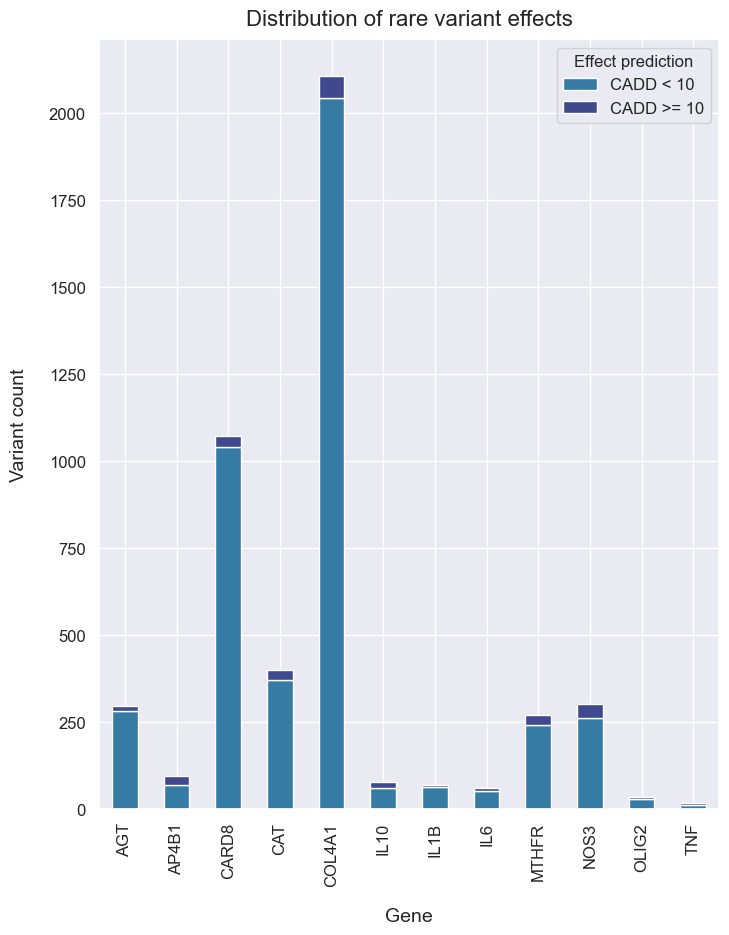

In [75]:
color_dict = dict(
    {"CADD < 10": "#357BA3", "CADD >= 10": "#40498E"}
)

pathogenicity_plot = functions.create_plot(
    data=pathogenicity_pivot,
    plot_type="stacked_barplot",
    palette=color_dict,
    legend_title="CADD prediction",
    legend_loc="upper right",
    x="GENE",
    horizontal_stack=False,
)

plt.xlabel(xlabel="Gene", labelpad=15)
plt.ylabel(ylabel="Variant count", labelpad=15)
plt.legend(title="Effect prediction", loc="upper right")
plt.title("Distribution of rare variant effects", size=constants.LARGEST_FONT, pad=10)

plt.savefig(
    "..\Results\Figures\Rare_variant_effects.png", dpi=1200, bbox_inches="tight"
)
plt.show()

Order rare variants with deleterious predictions based on their level of potential harm, with those predicted to be the most deleterious by various algorithms placed at the top of the table.

In [76]:
# Score rare variants based on number of deleterious effect predictions by various algorithms

vep_scored = ih_afr_subpops_vep_data[["ID","POS", "REF", "ALT", "GENE", "CADD_PHRED_SCORE"]].sort_values(by = ["CADD_PHRED_SCORE"], ascending=False)
vep_scored

,ID,POS,REF,ALT,GENE,CADD_PHRED_SCORE
2184,113895105_C_A,113895105,A,C,AP4B1,39.000
2237,113901338_A_T,113901338,T,A,AP4B1,32.000
166,110161349_A_G,110161349,G,A,COL4A1,32.000
2678,151001297_A_G,151001297,G,A,NOS3,31.000
2646,150998961_A_G,150998961,G,A,NOS3,30.000
...,...,...,...,...,...,...
32,110151696_C_CG,110151696,CG,C,COL4A1,0.002
2864,206768864_G_A,206768864,A,G,IL10,0.002
384,110179322_T_C,110179322,C,T,COL4A1,0.002
1548,110258005_A_C,110258005,C,A,COL4A1,0.001


Add information on the consequences of rare variants with predicted deleteriousness on a gene/protein.

In [77]:
# Add in consequence data for rare variants with predicted deleterious effects

vep_scored = vep_scored.merge(
    consequence_data,
    how="left",
    left_on=["ID", "REF", "ALT", "POS", "GENE"],
    right_on=["ID", "REF", "ALT", "POS", "GENE"],
)

vep_scored.head(11)

,ID,POS,REF,ALT,GENE,CADD_PHRED_SCORE,CHROM,TYPE,CONSEQUENCE_CLASSIFICATION,CONSEQUENCE
0,113895105_C_A,113895105,A,C,AP4B1,39.0,1,SNV,stop_gained,stop_gained
1,113901338_A_T,113901338,T,A,AP4B1,32.0,1,SNV,non_synonymous,missense
2,110161349_A_G,110161349,G,A,COL4A1,32.0,13,SNV,non_synonymous,missense
3,151001297_A_G,151001297,G,A,NOS3,31.0,7,SNV,non_synonymous,missense
4,150998961_A_G,150998961,G,A,NOS3,30.0,7,SNV,non_synonymous,missense
5,151001252_A_G,151001252,G,A,NOS3,29.4,7,SNV,non_synonymous,missense
6,34461370_A_G,34461370,G,A,CAT,29.3,11,SNV,non_synonymous,missense
7,11794442_G_C,11794442,C,G,MTHFR,27.8,1,SNV,non_synonymous,missense
8,151001313_C_G,151001313,G,C,NOS3,27.2,7,SNV,non_synonymous,missense
9,151010163_T_C,151010163,C,T,NOS3,27.1,7,SNV,non_synonymous,missense


Save results

In [78]:
# Save variant impact results

vep_scored.to_csv(
    os.path.join(
        PROJECT_ROOT,
        "Results",
        "Tables",
        "Variant_impact.csv",
    ),
    index=False,
)